In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[0])
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
# import KernelTools
# reload(KernelTools)
from KernelTools import *
# from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from EquationModel import CholInducedRKHS, OperatorPDEModel, OperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from Optimizers.full_jacobian import CholeskyLM, SVD_LM
from Optimizers.solvers_base import *
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results, get_nrmse    
from matplotlib import ticker
plt.style.use('default')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1 Step method

In [2]:
# Get Burgers data
def get_burgers_data(n_obs, n_coll_t, n_coll_x,run):

    # IC
    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0
                            
    
    # Solve Burgers' equations with IC 
    kappa = 0.001
    alpha = 5.
    u_true_function,ut_true_function,interp,_,_ = (build_burgers_data(func_u0=func_u0,
                                                                                   kappa = kappa,
                                                                                   alpha = alpha,
                                                                                   k_timestep=0.0001,
                                                                                   n_finite_diff=1999)
                                                        )

    # Collocation point set
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],n_coll_t,n_coll_x,alpha = 0.5)

    # Get (Y^m, u^m(Y^m))
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        n_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

    return tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp

In [3]:
tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(n_obs=60,n_coll_t=26, n_coll_x=31, run=55)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2997.19it/s]


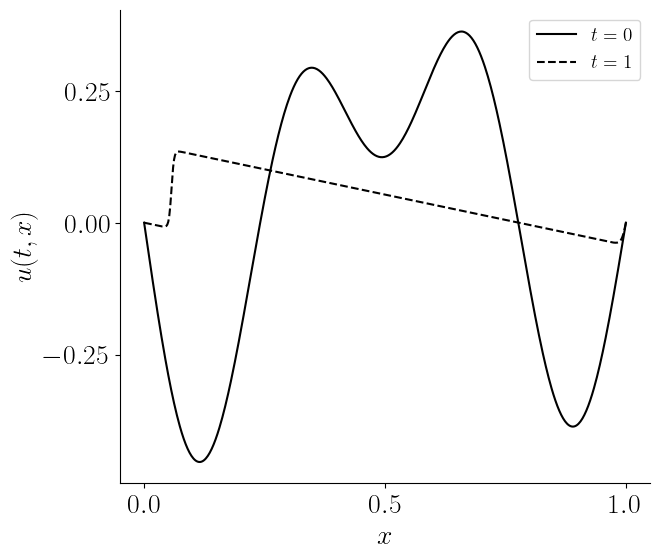

In [4]:
# INITIAL AND FINAL CONDITION PLOT
plt.figure(figsize=(7,6))
num_fine_grid = 500
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),color = 'black',label = r'$t=0$')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),linestyle = '--',color = 'black',label = r'$t=1$')
# Number of tick major labels
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('$x$')
plt.ylabel('$u(t,x)$')
plt.legend(loc="upper right",fontsize = 'x-small')
plt.tight_layout()
plt.savefig("burgers_init_final.png", dpi=300)
plt.show()

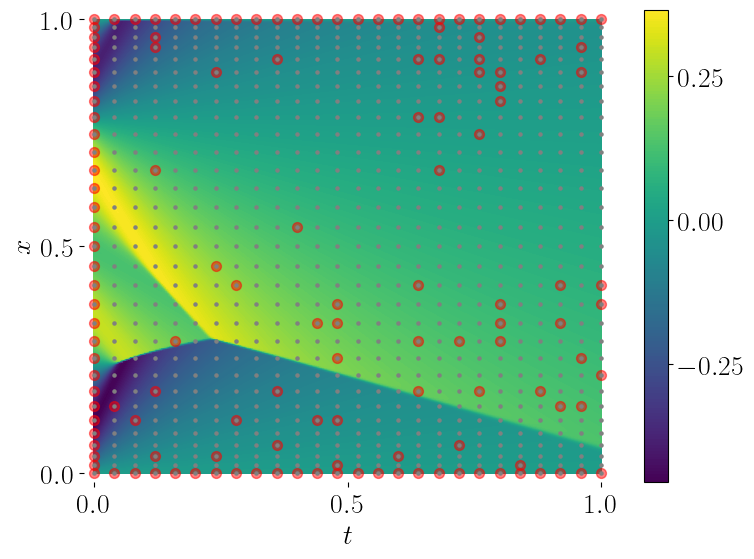

In [5]:
# U WITH COLL AND OBS PLOT
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T

def plot_input_data(
    obs_points,
    all_points,
    func_to_plot,
    fine_grid,
    xlabel = r'$t$',
    ylabel = r'$x$',
    include_collocation = True
):
    plt.figure(figsize=(8,6))

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),200)
    cb = plt.colorbar()
    tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 50, alpha = 0.5,label = "Function Value Observed")
    if include_collocation is True:
        plt.scatter(all_points[:,0],all_points[:,1],c='gray',s = 5,label = "Collocation Point")


plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=4)
plt.tight_layout()
# plt.savefig("burgers_data_shock.png", dpi=300)

In [44]:
def plot_function(
    obs_points,
    all_points,
    func,
    fine_grid,
    vmin,
    vmax,
    xlabel = '',
    ylabel = '',
    level_sets = 70,
    include_collocation = True,
    include_observations = True
):

    x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
    y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
    plt.tricontourf(*fine_grid.T,func(fine_grid),level_sets, vmin = vmin, vmax = vmax)
    # cb = plt.colorbar()
    # tick_locator = ticker.MaxNLocator(nbins=4)
    # cb.locator = tick_locator
    # cb.update_ticks()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
    plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=4)
    plt.tight_layout()
    if include_collocation is True:
        plt.scatter(*all_points.T,c='gray',s = 3,label = "Collocation Point")
    if include_observations is True:
        plt.scatter(*obs_points.T,c='red', s = 50, alpha = 0.5,label = "Function Value Observed")


-0.453787655164269
0.36259209976265067


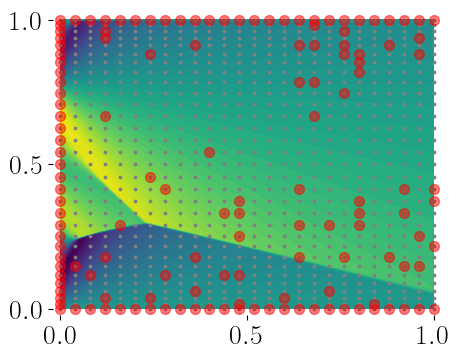

In [45]:
# True
vmin = min(u_true_function(tx_fine))
print(vmin)
vmax = max(u_true_function(tx_fine))
print(vmax)
plt.figure(figsize=(5,4))
plot_function(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
    vmin=-0.453787655164269,
    vmax=0.3887784971499098,
    level_sets=70,
)
# plt.gca().set_xticklabels([]) 
plt.savefig('shock_u_data.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

In [9]:
# Run 1 step method
# u_operators = (eval_k,)
u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

# Equation model that has u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

[0.18532524 0.1252437 ]


  1%|▏         | 3/201 [00:11<09:58,  3.02s/it]

Iteration 0, loss = 0.3738, gradnorm = 58.39, alpha = 2.5, improvement_ratio = 0.975
Iteration 1, loss = 0.2548, gradnorm = 27.0, alpha = 2.083, improvement_ratio = 1.012
Iteration 2, loss = 0.1835, gradnorm = 10.81, alpha = 1.736, improvement_ratio = 1.022


  2%|▏         | 5/201 [00:11<04:55,  1.51s/it]

Iteration 3, loss = 0.137, gradnorm = 5.291, alpha = 1.447, improvement_ratio = 1.023
Iteration 4, loss = 0.1052, gradnorm = 3.476, alpha = 1.206, improvement_ratio = 1.023
Iteration 5, loss = 0.08322, gradnorm = 3.662, alpha = 1.005, improvement_ratio = 1.019


 26%|██▋       | 53/201 [00:15<00:11, 12.98it/s]

Iteration 50, loss = 0.007643, gradnorm = 0.07366, alpha = 0.0002747, improvement_ratio = 1.035


 51%|█████     | 103/201 [00:19<00:07, 13.01it/s]

Iteration 100, loss = 0.002953, gradnorm = 0.213, alpha = 3.019e-08, improvement_ratio = 1.002


 76%|███████▌  | 153/201 [00:23<00:03, 13.01it/s]

Iteration 150, loss = 0.002366, gradnorm = 0.002666, alpha = 8.333e-09, improvement_ratio = 1.004


100%|██████████| 201/201 [00:26<00:00,  7.50it/s]


Iteration 200, loss = 0.002256, gradnorm = 0.001842, alpha = 8.333e-09, improvement_ratio = 1.002


  1%|          | 2/201 [00:11<15:25,  4.65s/it]

Iteration 0, loss = 0.002256, gradnorm = 0.001483, alpha = 3.0, improvement_ratio = 0.7085
Iteration 1, loss = 0.002256, gradnorm = 1.051e-05, alpha = 2.5, improvement_ratio = 2.241


  2%|▏         | 4/201 [00:11<05:25,  1.65s/it]

Iteration 2, loss = 0.002256, gradnorm = 5.864e-06, alpha = 2.083, improvement_ratio = 1.492
Iteration 3, loss = 0.002256, gradnorm = 6.038e-06, alpha = 1.736, improvement_ratio = 3.111


  3%|▎         | 6/201 [00:11<02:39,  1.22it/s]

Iteration 4, loss = 0.002256, gradnorm = 3.874e-06, alpha = 3.255, improvement_ratio = 2.229
Iteration 5, loss = 0.002256, gradnorm = 5.269e-06, alpha = 7.324, improvement_ratio = 0.4642


  4%|▍         | 8/201 [00:12<05:07,  1.59s/it]

Line Search Failed!
Final Iteration Results
Iteration 8, loss = 0.002256, gradnorm = 3.358e-06, alpha = 2.435e+04, improvement_ratio = -6.809e+04


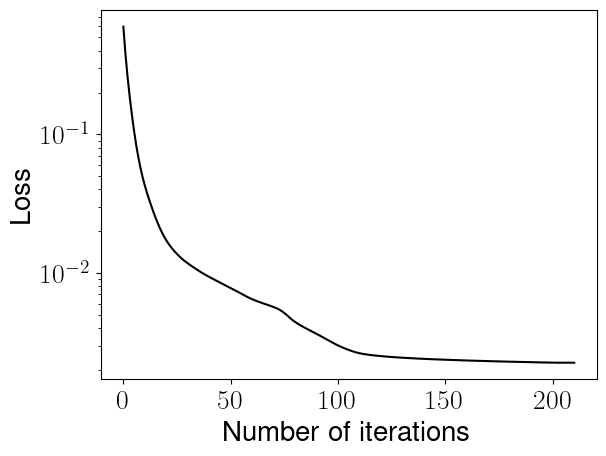

In [10]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
optparams = LMParams(max_iter = 201)

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    optParams = optparams
)

params_adjusted,refine_convergence_data = SVD_LM(
    params,
    EqnModel,
    beta = 1e-11,
    optParams = optparams)
# Convergence history
plt.plot(jnp.hstack([convergence_data.loss_vals,refine_convergence_data.loss_vals]), color = 'black')
plt.xlabel(r'Number of iterations')
plt.ylabel(r'Loss')
plt.yscale('log')
plt.show()

In [39]:
# Extract u and P coefficients
u_sol = params_adjusted[:u_model.num_params]
P_sol = params_adjusted[u_model.num_params:]

-0.451697105076164
0.35511371411848813


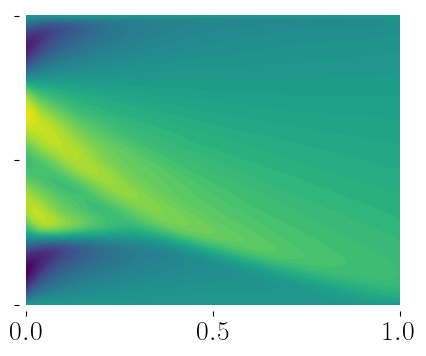

In [42]:
# 1-step 
vmin = min(u_model.point_evaluate(tx_fine,u_sol))
print(vmin)
vmax = max(u_model.point_evaluate(tx_fine,u_sol))
print(vmax)
plt.figure(figsize=(5,4))
plot_function(
    tx_obs,
    tx_all,
    lambda grid: u_model.point_evaluate(grid,u_sol),
    tx_fine,
    vmin =-0.453787655164269,
    vmax=0.3887784971499098,
    level_sets=70,
    include_collocation=False,
    include_observations=False
)
# plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('shock_u_pred_1step.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

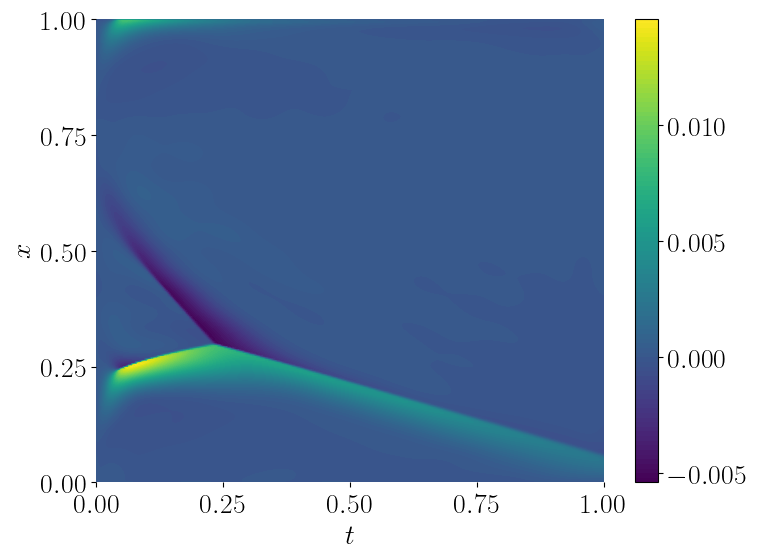

In [ ]:
# Error Uhat 1 step method plot 
plt.figure(figsize=(8,6))
plt.xlabel('$t$')
plt.ylabel('$x$')
# plt.ylabel('$x$')
# plt.xlim(0 - 0.05,1 + 0.05)
# plt.ylim(0 - 0.05,1 + 0.05)
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
u_pred = u_model.point_evaluate(tx_fine,u_sol)
u_true = u_true_function(tx_fine)
plt.tricontourf(*tx_fine.T,(u_pred-u_true)/jnp.linalg.norm(u_true),100)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# Remove lines surrounding plot
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.locator_params(nbins=4)
plt.tight_layout()
plt.savefig("burgers_shock_error_1step.png",dpi=300)
plt.show()

In [11]:
print(get_nrmse(u_true,u_pred))

0.3967661051358963


### SINDy

In [34]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    # Initial guess: Least-squares
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0]

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coeffs.
        Xi[smallinds]=0 # and threshold
        for ind in range(n): # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,
                biginds],dXdt[:,ind],rcond=None)[0]
        return Xi

In [35]:
tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(n_obs=60,n_coll_t=26, n_coll_x=31, run=55)

  0%|          | 0/10099 [00:00<?, ?it/s]

100%|██████████| 10099/10099 [00:03<00:00, 2783.82it/s]


In [36]:
# Run SINDy
u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dt_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_SINDy = u_model.get_fitted_params(tx_obs,u_obs)


S = (u_model.evaluate_operators(feature_operators,tx_int,u_params_SINDy).reshape(
            len(tx_int), 
            len(feature_operators),
            order = 'F'
                ))

CONST = jnp.ones(len(S[:,0]))
U = S[:,0]
U_t = S[:,1]
U_x = S[:,2]
U_xx = S[:,3]
UU = jnp.multiply(S[:,0],S[:,0])
UU_x = jnp.multiply(S[:,0],S[:,2])
UU_xx = jnp.multiply(S[:,0],S[:,3])
U_xU_x = jnp.multiply(S[:,2],S[:,2])
U_xU_xx = jnp.multiply(S[:,2],S[:,3])
U_xxU_xx = jnp.multiply(S[:,3],S[:,3])



Theta = jnp.vstack([CONST,U,U_x,U_xx,
                    UU,UU_x,UU_xx,U_xU_x,
                    U_xU_xx,U_xxU_xx]).T


res_SINDy = sparsifyDynamics(Theta,U_t.reshape(-1,1),lamb = 1e-8, n = 1)

[0.18532524 0.1252437 ]


-0.4537810700148963
0.3887784971499098


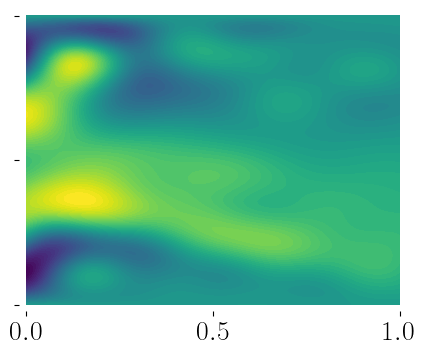

In [38]:
# Interp
vmin = min(u_model.point_evaluate(tx_fine,u_params_SINDy))
print(vmin)
vmax = max(u_model.point_evaluate(tx_fine,u_params_SINDy))
print(vmax)
plt.figure(figsize=(5,4))
plot_function(
    tx_obs,
    tx_all,
    lambda grid: u_model.point_evaluate(grid,u_params_SINDy),
    tx_fine,
    vmin=-0.453787655164269,
    vmax=0.3887784971499098,
    level_sets=70,
    include_collocation=False,
    include_observations=False
)
# plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('shock_u_pred_interp.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

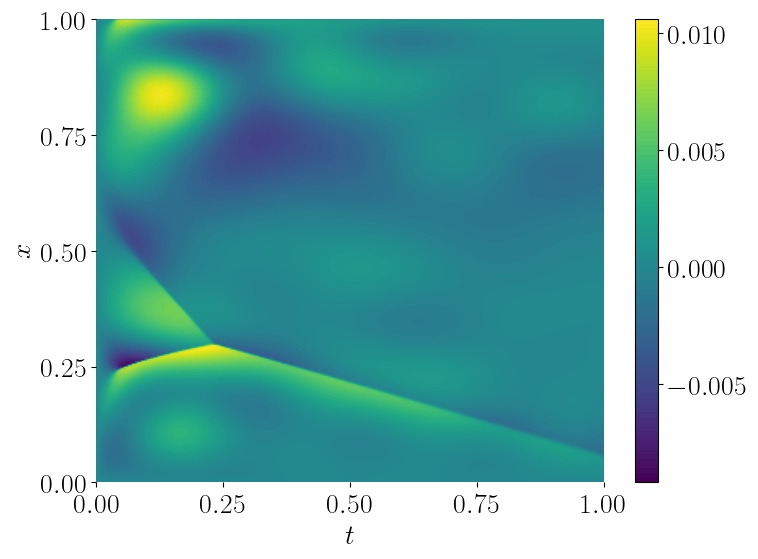

In [16]:
# Error Uhat SINDy method plot 
plt.figure(figsize=(8,6))
plt.xlabel('$t$')
plt.ylabel('$x$')
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
u_pred = u_model.point_evaluate(tx_fine,u_sol)
u_true = u_true_function(tx_fine)
plt.tricontourf(*tx_fine.T,(u_pred-u_true)/jnp.linalg.norm(u_true),100)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# Remove lines surrounding plot
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.locator_params(nbins=4)
plt.tight_layout()
plt.savefig("burgers_shock_error_SINDy.png",dpi=300)
plt.show()

In [17]:
print(get_nrmse(u_true,u_pred))

0.6283384271690161


### PINNSR

In [44]:
def get_data_for_pinns(n_obs, n_coll_t, n_coll_x,run):
    
    # IC
    def func_u0(x):
        u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
        return u0
                            
    
    # Solve Burgers' equations with IC 
    kappa = 0.001
    alpha = 5.
    u_true_function,ut_true_function,interp,_,_ = (build_burgers_data(func_u0=func_u0,
                                                                                   kappa = kappa,
                                                                                   alpha = alpha,
                                                                                   k_timestep=0.0001,
                                                                                   n_finite_diff=1999)
                                                        )
    
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    
    # Invert them to be ready for PINNSR 
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    # plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)
    
    # plot_input_data(
    #     tx_train, 
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    #             )
    
    def plot_input_data(
        obs_points,
        all_points,
        func_to_plot,
        fine_grid,
        xlabel = r'$t$',
        ylabel = r'$x$',
        include_collocation = True
    ):
        plt.figure(figsize=(8,6))

        x_bounds = jnp.min(fine_grid[:,0]),jnp.max(fine_grid[:,0])
        y_bounds = jnp.min(fine_grid[:,1]),jnp.max(fine_grid[:,1])
        plt.tricontourf(fine_grid[:,0],fine_grid[:,1],func_to_plot(fine_grid),200)
        cb = plt.colorbar()
        tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator
        cb.update_ticks()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
        plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
        plt.scatter(obs_points[:,0],obs_points[:,1],c='red', s = 50, alpha = 0.5,label = "Function Value Observed")
        if include_collocation is True:
            plt.scatter(all_points[:,0],all_points[:,1],c='gray',s = 5,label = "Collocation Point")
        #plt.figlegend(loc = 'upper center')


    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
    )
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    plt.locator_params(nbins=4)
    # plt.savefig('burgers_smooth',dpi = 300)
    plt.show()

    plt.figure(figsize=(7,6))
    num_fine_grid = 500
    grid_points = jnp.linspace(0,1,num_fine_grid)
    plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),color = 'black',label = r'$t=0$')
    plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),linestyle = '--',color = 'black',label = r'$t=1$')
    # Number of tick major labels
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=4)
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # More settings
    plt.xlabel('$x$')
    plt.ylabel('$u(t,x)$')
    plt.legend(loc="upper right",fontsize = 'x-small')
    plt.tight_layout()
    # plt.savefig('burgers_smooth_init_final',dpi = 300)
    plt.show()

    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    u_true = u_true_function(tx_fine)

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    

    return [u_true, tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

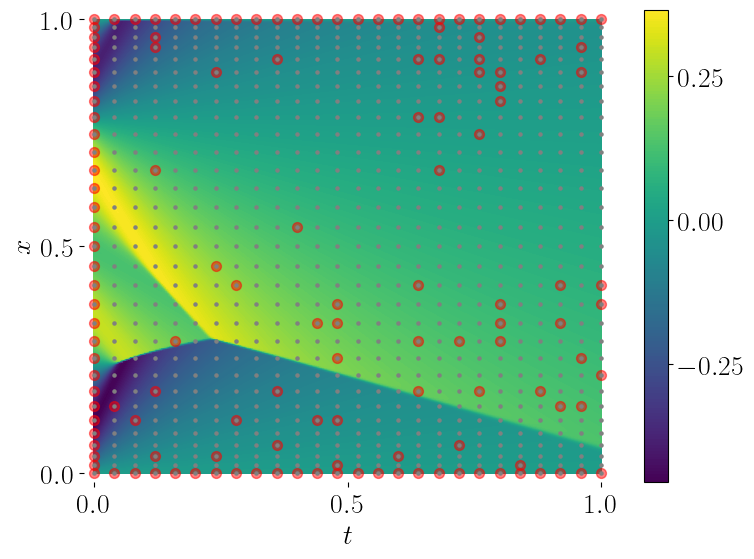

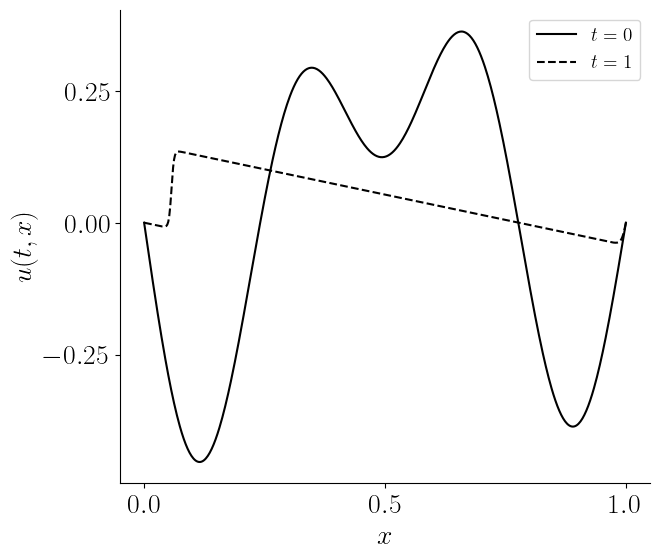

In [45]:
data_in_PINNSR_test = get_data_for_pinns(n_obs=60,n_coll_t=26, n_coll_x=31, run=55)
# data_in_PINNSR_test = get_data_for_pinns(n_obs=1000,n_coll_t=223, n_coll_x=225, run=55)
data_in_PINNSR_test = list(map(np.array,data_in_PINNSR_test))

In [46]:
np.save('data_in_PINNSR_test.npy', np.array(data_in_PINNSR_test, dtype=object), allow_pickle=True)

Load PINNSR coefficients and data from here

In [23]:
data_out_PINNSR_test = jnp.load('data_out_PINNSR_test.npy',allow_pickle = True)

In [27]:
data_out_PINNSR_test

array([array([[ 0.       ],
              [-2.8727758],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ],
              [ 0.       ]], dtype=float32),
       array([[-0.0006687 ],
              [ 0.01578456],
              [ 0.02925697],
              ...,
              [ 0.00018334],
              [ 0.00014785],
              [ 0.0001117 ]], dtype=float32)], dtype=object)

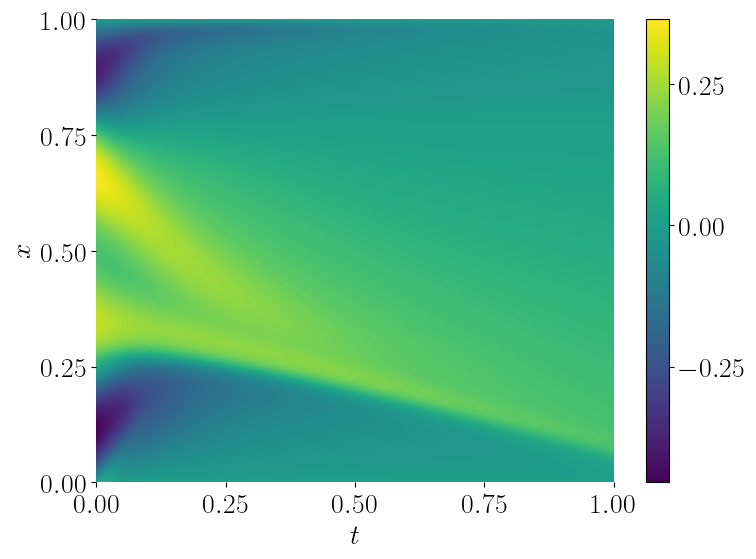

In [28]:
# Uhat PINNSR method plot
plt.figure(figsize=(8,6))
plt.xlabel('$t$')
plt.ylabel('$x$')
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plt.tricontourf(*tx_fine.T,data_out_PINNSR_test[1].flatten(),200)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# Remove lines surrounding plot
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
# Use less major ticks
plt.locator_params(nbins=4)
# Layout
plt.tight_layout()
# Save fig
plt.savefig("burgers_shock_learned_PINNSR.png",dpi=300)
plt.show()

-0.45288315
0.3628667


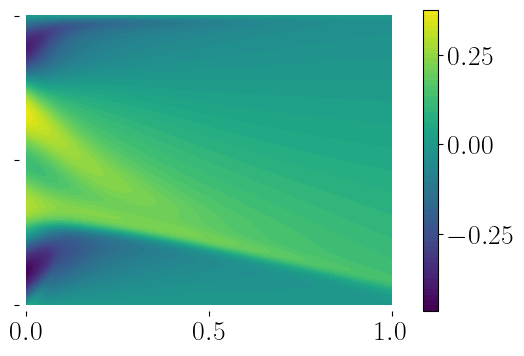

In [33]:
plt.figure(figsize=(6,4))
x_bounds = jnp.min(tx_fine[:,0]),jnp.max(tx_fine[:,0])
y_bounds = jnp.min(tx_fine[:,1]),jnp.max(tx_fine[:,1])
pred = data_out_PINNSR_test[1].flatten()
vmin = min(pred)
print(vmin)
vmax = max(pred)
print(vmax)
cp = plt.tricontourf(*tx_fine.T,pred,70, vmin= -0.453787655164269, vmax = 0.3887784971499098)
cb = plt.colorbar(cp)
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
plt.xlim(x_bounds[0] - 0.02,x_bounds[1] + 0.02)
plt.ylim(y_bounds[0] - 0.02,y_bounds[1] + 0.02)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.locator_params(nbins=4)
plt.tight_layout()
# plt.gca().set_xticklabels([]) 
plt.gca().set_yticklabels([])
plt.savefig('shock_u_pred_PINNSR.pdf',
            dpi=300,
            bbox_inches='tight',
            format ="pdf"
            )

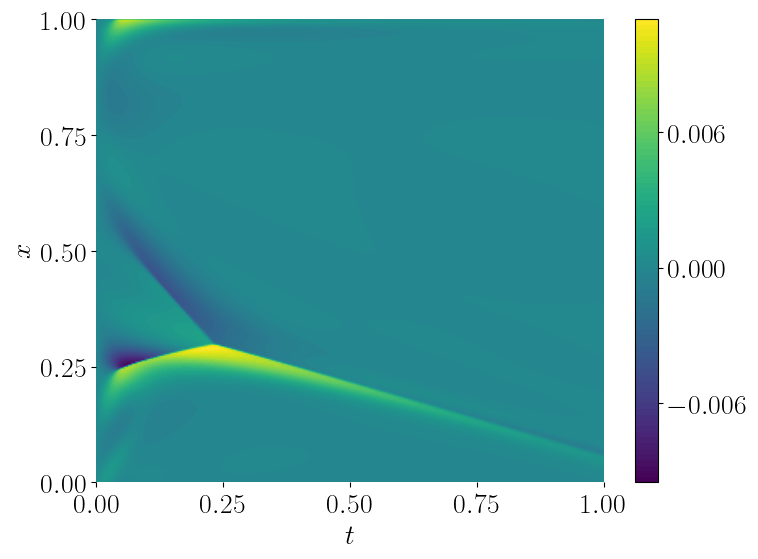

In [21]:
# Error Uhat PINNSR method plot 
plt.figure(figsize=(8,6))
plt.xlabel('$t$')
plt.ylabel('$x$')
t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
u_pred = data_out_PINNSR_test[1].flatten()
u_true = u_true_function(tx_fine)
plt.tricontourf(*tx_fine.T,(u_pred-u_true)/jnp.linalg.norm(u_true),100)
cb = plt.colorbar()
tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator
cb.update_ticks()
# Remove lines surrounding plot
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.locator_params(nbins=4)
plt.tight_layout()
plt.savefig("burgers_shock_error_PINNSR.png",dpi=300)
plt.show()